# Exploratory Data Analysis

Chapter 2

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from distribution import Pmf, Cdf

In [2]:
def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

## Loading and validation


In [3]:
import re

class FixedWidthVariables(object):
    """Represents a set of variables in a fixed width file."""

    def __init__(self, variables, index_base=0):
        """Initializes.

        variables: DataFrame
        index_base: are the indices 0 or 1 based?

        Attributes:
        colspecs: list of (start, end) index tuples
        names: list of string variable names
        """
        self.variables = variables

        # note: by default, subtract 1 from colspecs
        self.colspecs = variables[['start', 'end']] - index_base

        # convert colspecs to a list of pair of int
        self.colspecs = self.colspecs.astype(np.int).values.tolist()
        self.names = variables['name']

    def ReadFixedWidth(self, filename, **options):
        """Reads a fixed width ASCII file.

        filename: string filename

        returns: DataFrame
        """
        df = pd.read_fwf(filename,
                         colspecs=self.colspecs, 
                         names=self.names,
                         **options)
        return df


def ReadStataDct(dct_file, **options):
    """Reads a Stata dictionary file.

    dct_file: string filename
    options: dict of options passed to open()

    returns: FixedWidthVariables object
    """
    type_map = dict(byte=int, int=int, long=int, float=float, 
                    double=float, numeric=float)

    var_info = []
    with open(dct_file, **options) as f:
        for line in f:
            match = re.search( r'_column\(([^)]*)\)', line)
            if not match:
                continue
            start = int(match.group(1))
            t = line.split()
            vtype, name, fstring = t[1:4]
            name = name.lower()
            if vtype.startswith('str'):
                vtype = str
            else:
                vtype = type_map[vtype]
            long_desc = ' '.join(t[4:]).strip('"')
            var_info.append((start, vtype, name, fstring, long_desc))
            
    columns = ['start', 'type', 'name', 'fstring', 'desc']
    variables = pd.DataFrame(var_info, columns=columns)

    # fill in the end column by shifting the start column
    variables['end'] = variables.start.shift(-1)
    variables.loc[len(variables)-1, 'end'] = 0

    dct = FixedWidthVariables(variables, index_base=1)
    return dct

def read_gss(dirname):
    """Reads GSS files from the given directory.
    
    dirname: string
    
    returns: DataFrame
    """
    dct = ReadStataDct(dirname + '/GSS.dct')
    gss = dct.ReadFixedWidth(dirname + '/GSS.dat.gz',
                             compression='gzip')
    return gss

In [4]:
gss = read_gss('gss_eda')
print(gss.shape)
gss.head()

(62466, 101)


,year,id_,agewed,divorce,sibs,childs,age,educ,paeduc,maeduc,...,memchurh,realinc,cohort,marcohrt,ballot,wtssall,adults,compuse,databank,wtssnr
0,1972,1,0,0,3,0,23,16,10,97,...,0,18951.0,1949,0,0,0.4446,1,0,0,1.0
1,1972,2,21,2,4,5,70,10,8,8,...,0,24366.0,1902,1923,0,0.8893,2,0,0,1.0
2,1972,3,20,2,5,4,48,12,8,8,...,0,24366.0,1924,1944,0,0.8893,2,0,0,1.0
3,1972,4,24,2,5,0,27,17,16,12,...,0,30458.0,1945,1969,0,0.8893,2,0,0,1.0
4,1972,5,22,2,2,2,61,12,8,8,...,0,50763.0,1911,1933,0,0.8893,2,0,0,1.0


In [5]:
gss[gss.year==2016].adults.value_counts().sort_index()

1     994
2    1436
3     317
4      88
5      23
6       6
8       2
9       1
Name: adults, dtype: int64

In [6]:
def replace_invalid(df):
    df.realinc.replace([0], np.nan, inplace=True)                  
    df.educ.replace([98,99], np.nan, inplace=True)
    # 89 means 89 or older
    df.age.replace([98, 99], np.nan, inplace=True) 
    df.cohort.replace([9999], np.nan, inplace=True)
    df.adults.replace([9], np.nan, inplace=True)

replace_invalid(gss)

The proportion of women in this dataset is slightly higher than it probably is in the population, even after weighting.

In [7]:
sex = gss.loc[gss.year==2010, 'sex']

In [8]:
pmf = Pmf([1,2])
pmf[1] = np.sum(sex==1)
pmf[2] = np.sum(sex==2)
pmf.normalize()
pmf

1    0.43591
2    0.56409
Name: Pmf, dtype: float64

In [9]:
pmf = Pmf([1,2])
pmf[1] = np.sum((sex==1) * gss.wtssall)
pmf[2] = np.sum((sex==2) * gss.wtssall)
pmf.normalize()
pmf

1    0.451634
2    0.548366
Name: Pmf, dtype: float64

In [11]:
pmf = Pmf([1,2])
pmf[1] = np.sum((sex==1) * gss.wtssnr)
pmf[2] = np.sum((sex==2) * gss.wtssnr)
pmf.normalize()
pmf

1    0.453784
2    0.546216
Name: Pmf, dtype: float64

In [10]:
pmf = Pmf([1,2])
pmf[1] = np.sum((sex==1) * gss.wtssall * gss.adults)
pmf[2] = np.sum((sex==2) * gss.wtssall * gss.adults)
pmf.normalize()
pmf

1    0.463868
2    0.536132
Name: Pmf, dtype: float64

In [146]:
m = 114179053
f = 121044963
f / (m+f)

0.5145944068908338

In [133]:
gss['wtsample'] = gss['wtssall'] * gss['adults']

In [134]:
variables = ['year', 'age', 'cohort', 'sex', 'race', 
             'educ', 'realinc', 'adults', 'wtssall', 'wtsample']

subset = gss[variables]
subset.head()

,year,age,cohort,sex,race,educ,realinc,adults,wtssall,wtsample
0,1972,27.0,1945.0,2,2,12.0,8122.0,2.0,0.8893,1.7786
1,1972,59.0,1913.0,2,1,12.0,37226.0,3.0,1.3339,4.0017
2,1972,22.0,1950.0,1,1,11.0,NaN,3.0,1.3339,4.0017
3,1972,70.0,1902.0,1,1,12.0,18951.0,2.0,0.8893,1.7786
4,1972,28.0,1944.0,1,1,16.0,43994.0,2.0,0.8893,1.7786


In [135]:
# drop the 65 respondents with unknown household size
subset = subset.dropna(subset=['adults'])

In [136]:
np.random.seed(19)
sample = utils.resample_by_year(subset, 'wtsample')

In [18]:
sample.to_hdf('gss.hdf5', 'gss')

In [19]:
%time gss = pd.read_hdf('gss.hdf5', 'gss')
gss.shape

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.6 ms


(62401, 10)

In [20]:
gss.head()

,year,age,cohort,sex,race,educ,realinc,adults,wtssall,wtsample
0,1972,27.0,1945.0,2,2,12.0,8122.0,2.0,0.8893,1.7786
1,1972,59.0,1913.0,2,1,12.0,37226.0,3.0,1.3339,4.0017
2,1972,22.0,1950.0,1,1,11.0,NaN,3.0,1.3339,4.0017
3,1972,70.0,1902.0,1,1,12.0,18951.0,2.0,0.8893,1.7786
4,1972,28.0,1944.0,1,1,16.0,43994.0,2.0,0.8893,1.7786


In [21]:
gss['year'].describe()

count    62401.000000
mean      1994.066842
std         12.933748
min       1972.000000
25%       1984.000000
50%       1994.000000
75%       2006.000000
max       2016.000000
Name: year, dtype: float64

In [22]:
gss['sex'].describe()

count    62401.000000
mean         1.531113
std          0.499035
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: sex, dtype: float64

In [23]:
gss['age'].describe()

count    62246.000000
mean        43.306124
std         16.774853
min         18.000000
25%         29.000000
50%         42.000000
75%         55.000000
max         89.000000
Name: age, dtype: float64

In [24]:
gss['cohort'].describe()

count    62247.000000
mean      1950.762607
std         20.601535
min       1883.000000
25%       1937.000000
50%       1952.000000
75%       1965.000000
max       1998.000000
Name: cohort, dtype: float64

In [25]:
gss['race'].describe()

count    62401.000000
mean         1.276422
std          0.581926
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: race, dtype: float64

In [26]:
gss['educ'].describe()

count    62221.000000
mean        12.775976
std          3.103969
min          0.000000
25%         12.000000
50%         12.000000
75%         15.000000
max         20.000000
Name: educ, dtype: float64

In [27]:
gss['realinc'].describe()

count     54919.000000
mean      37064.903303
std       31843.484493
min         234.000000
25%       15372.500000
50%       28323.000000
75%       46507.000000
max      162607.000000
Name: realinc, dtype: float64

In [28]:
gss['wtssall'].describe()

count    62401.000000
mean         1.413739
std          0.673388
min          0.391825
25%          1.007200
50%          1.100100
75%          1.673400
max          8.739876
Name: wtssall, dtype: float64

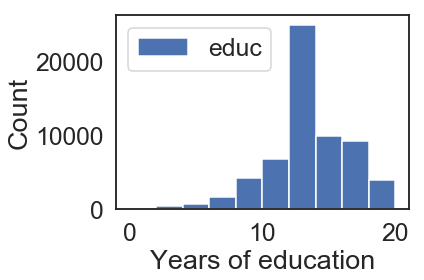

In [29]:
educ = gss['educ']
plt.hist(educ.dropna(), label='educ')
decorate(xlabel='Years of education',
         ylabel='Count')
plt.savefig('educ_hist.png')

In [30]:
pmf_educ = Pmf(educ, normalize=False, name='educ')
pmf_educ.head()

0.0    178
1.0     51
2.0    167
3.0    262
4.0    272
Name: educ, dtype: int64

In [31]:
pmf_educ = Pmf(educ, normalize=True)
pmf_educ.head()

0.0    0.002861
1.0    0.000820
2.0    0.002684
3.0    0.004211
4.0    0.004372
Name: Pmf, dtype: float64

In [32]:
pmf_educ[12]

0.3131740087751724

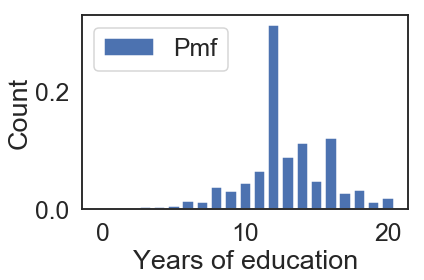

In [33]:
pmf_educ.bar()
decorate(xlabel='Years of education',
         ylabel='Count')

In [34]:
pmf_educ[12]

0.3131740087751724

In [35]:
pmf_educ[13] + pmf_educ[14] + pmf_educ[15] + pmf_educ[16]

0.3694572571961235

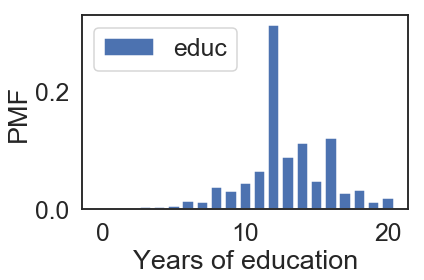

In [36]:
pmf_educ.normalize()
pmf_educ.bar(label='educ')
decorate(xlabel='Years of education',
         ylabel='PMF')

plt.savefig('educ_pmf.png')

In [37]:
pmf_educ[12]

0.3131740087751724

In [38]:
pmf_educ[13] + pmf_educ[14] + pmf_educ[15] + pmf_educ[16]

0.3694572571961235

In [39]:
pmf_educ[13:16]

13.0    0.088475
14.0    0.112984
15.0    0.047154
16.0    0.120843
Name: Pmf, dtype: float64

In [40]:
pmf_educ[13:16].sum()

0.3694572571961235

In [41]:
year = gss['year']
pmf_year = Pmf(year)
pmf_year

1972    0.025849
1973    0.024102
1974    0.023750
1975    0.023878
1976    0.023990
1977    0.024471
1978    0.024439
1980    0.023413
1982    0.029791
1983    0.025625
1984    0.023605
1985    0.024583
1986    0.023557
1987    0.029150
1988    0.023734
1989    0.024631
1990    0.021987
1991    0.024311
1993    0.025737
1994    0.047948
1996    0.046538
1998    0.045368
2000    0.045111
2002    0.044310
2004    0.044999
2006    0.072274
2008    0.032355
2010    0.032660
2012    0.031378
2014    0.040528
2016    0.045929
Name: Pmf, dtype: float64

In [42]:
year = gss['year']
pmf_year = Pmf(year, normalize=False)
pmf_year

1972    1613
1973    1504
1974    1482
1975    1490
1976    1497
1977    1527
1978    1525
1980    1461
1982    1859
1983    1599
1984    1473
1985    1534
1986    1470
1987    1819
1988    1481
1989    1537
1990    1372
1991    1517
1993    1606
1994    2992
1996    2904
1998    2831
2000    2815
2002    2765
2004    2808
2006    4510
2008    2019
2010    2038
2012    1958
2014    2529
2016    2866
Name: Pmf, dtype: int64

In [43]:
race = gss['race']

race.value_counts().sort_index()

1    49477
2     8599
3     4325
Name: race, dtype: int64

In [44]:
pmf_race = Pmf(race, name='race', normalize=False)
pmf_race

1    49477
2     8599
3     4325
Name: race, dtype: int64

In [45]:
pmf_race.qs

array([1, 2, 3])

In [46]:
pmf_race.ps

array([49477,  8599,  4325])

In [47]:
pmf_race(1)

49477

In [48]:
pmf_race(4)

0

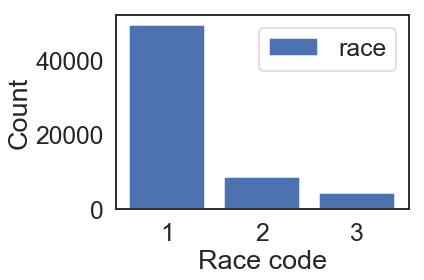

In [49]:
pmf_race.bar()
decorate(xlabel='Race code', ylabel='Count')

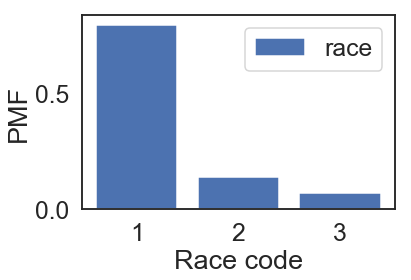

In [50]:
pmf_race.normalize()
pmf_race.bar()
decorate(xlabel='Race code', ylabel='PMF')

In [51]:
pmf_race(2)

0.13780227880963447

In [52]:
age = gss['age']
pmf_age = Pmf(age, name='age')

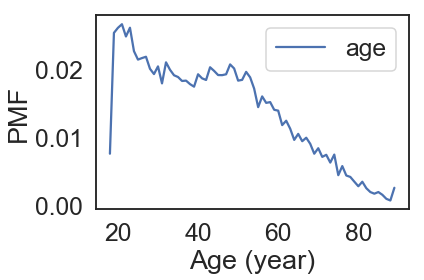

In [53]:
pmf_age.plot()
decorate(xlabel='Age (year)', ylabel='PMF')

In [54]:
cdf_age = Cdf(age, name='Age')

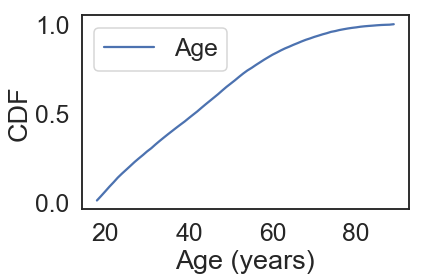

In [55]:
cdf_age.plot()
decorate(xlabel='Age (years)', ylabel='CDF')

In [56]:
cdf_age.forward(51)

array(0.68410822)

In [57]:
cdf_age.inverse(0.5)

array(42.)

### Variable `realinc`

Family income on 1972-2006 surveys in constant dollars (base = 1986)

https://gssdataexplorer.norc.org/variables/5198/vshow


In [58]:
income = gss['realinc']
pmf_income = Pmf(income, name='income')

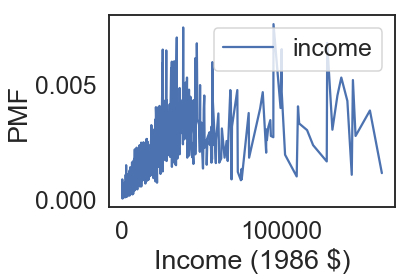

In [59]:
pmf_income.plot()
decorate(xlabel='Income (1986 $)', ylabel='PMF')

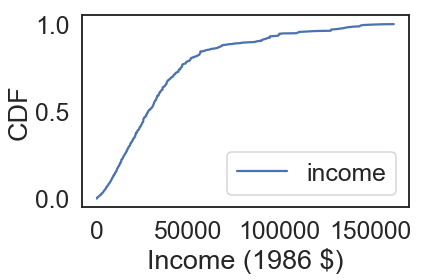

In [60]:
cdf_income = Cdf(income, name='income')
cdf_income.plot()
decorate(xlabel='Income (1986 $)', ylabel='CDF')

In [61]:
recent = gss['year'] >= 2010

In [62]:
female = gss['sex'] == 2
male = gss['sex'] == 1

In [63]:
female.mean()

0.5311132834409705

In [64]:
male.mean()

0.4688867165590295

In [65]:
age = gss['age']

In [70]:
pmf_age_male = Pmf(age[recent&male], 
                   name='Male')
pmf_age_female = Pmf(age[recent&female], 
                     name='Female')

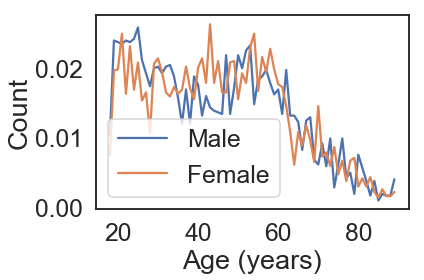

In [71]:
pmf_age_male.plot()
pmf_age_female.plot()
decorate(xlabel='Age (years)', ylabel='Count')

In [72]:
cdf_age_male = Cdf(age[recent&male], 
                   name='Male')
cdf_age_female = Cdf(age[recent&female], 
                     name='Female')

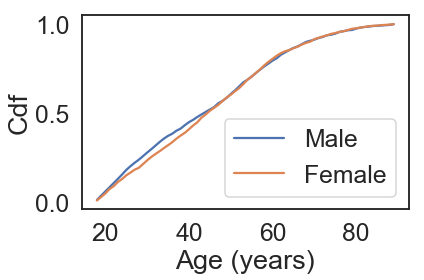

In [73]:
cdf_age_male.plot()
cdf_age_female.plot()
decorate(xlabel='Age (years)', ylabel='Cdf')

In [74]:
educ = gss['educ']

In [76]:
post = educ > 16
bach = ~post & (educ > 14)
assc = ~bach & (educ > 12)
high = educ <= 12

In [77]:
post.mean()

0.09142481690998541

In [78]:
bach.mean()

0.16751334113235364

In [79]:
assc.mean()

0.29230300796461595

In [80]:
high.mean()

0.5372990817454848

In [82]:
income = gss['realinc']

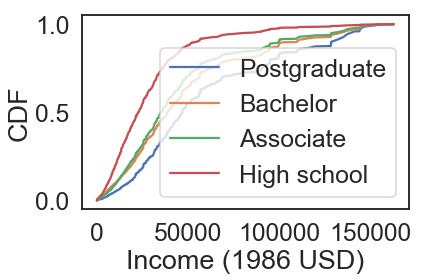

In [87]:
Cdf(income[post]).plot(label='Postgraduate')
Cdf(income[bach]).plot(label='Bachelor')
Cdf(income[assc]).plot(label='Associate')
Cdf(income[high]).plot(label='High school')
decorate(xlabel='Income (1986 USD)',
         ylabel='CDF')

In [110]:
sample = np.random.normal(size=1000)

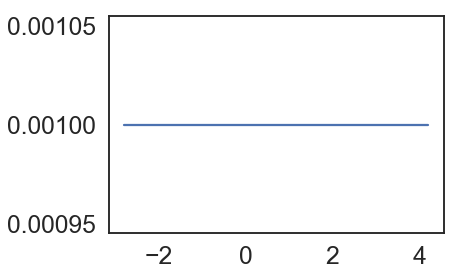

In [97]:
Pmf(sample).plot()

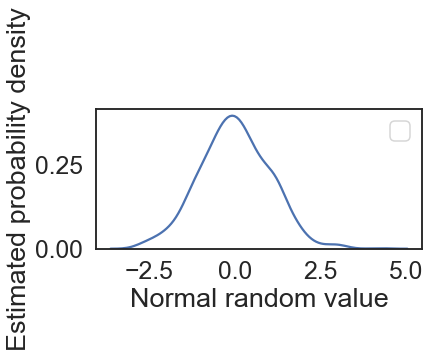

In [103]:
from warnings import simplefilter
simplefilter('ignore', FutureWarning)

sns.kdeplot(sample)
decorate(xlabel='Normal random value',
         ylabel='Estimated probability density')

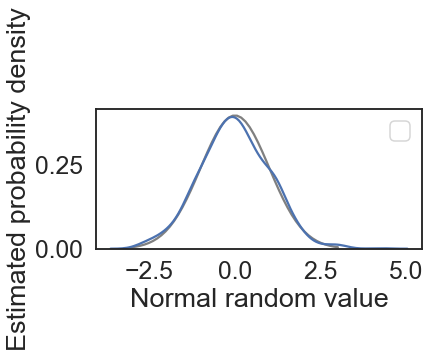

In [107]:
from scipy.stats import norm

xs = np.linspace(-3, 3)
ys = norm.pdf(xs)
plt.plot(xs, ys, color='gray')
sns.kdeplot(sample)
decorate(xlabel='Normal random value',
         ylabel='Estimated probability density')

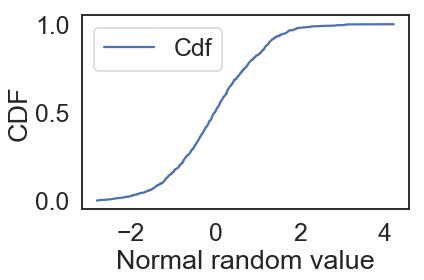

In [108]:
Cdf(sample).plot()
decorate(xlabel='Normal random value',
         ylabel='CDF')

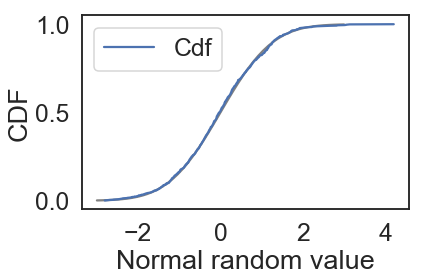

In [109]:
xs = np.linspace(-3, 3)
ys = norm.cdf(xs)
plt.plot(xs, ys, color='gray')

Cdf(sample).plot()
decorate(xlabel='Normal random value',
         ylabel='CDF')

In [111]:
sample = np.random.exponential(size=1000)

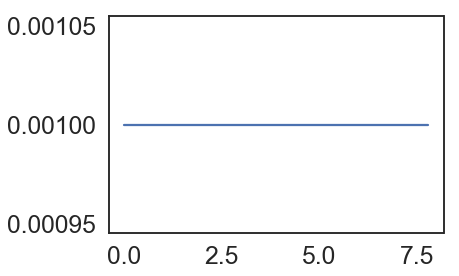

In [112]:
Pmf(sample).plot()

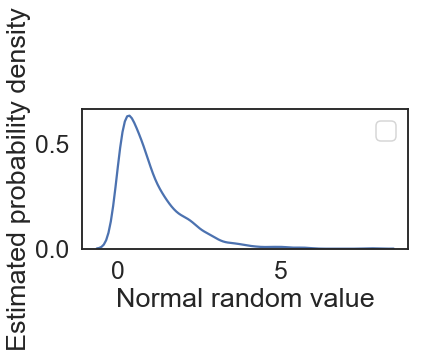

In [113]:
from warnings import simplefilter
simplefilter('ignore', FutureWarning)

sns.kdeplot(sample)
decorate(xlabel='Normal random value',
         ylabel='Estimated probability density')

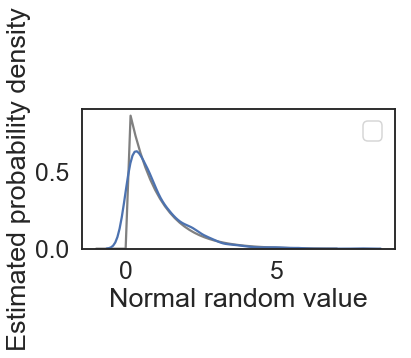

In [119]:
from scipy.stats import expon

xs = np.linspace(-1, 7)
ys = expon.pdf(xs)
plt.plot(xs, ys, color='gray')
sns.kdeplot(sample)
decorate(xlabel='Normal random value',
         ylabel='Estimated probability density')

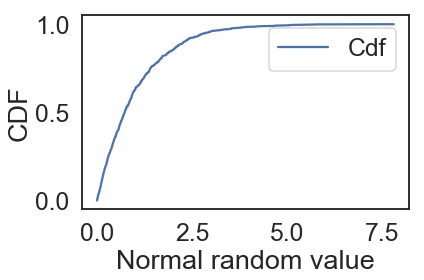

In [115]:
Cdf(sample).plot()
decorate(xlabel='Normal random value',
         ylabel='CDF')

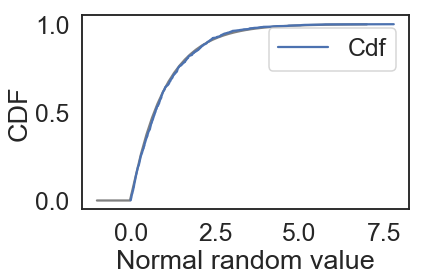

In [118]:
xs = np.linspace(-1,7)
ys = expon.cdf(xs)
plt.plot(xs, ys, color='gray')

Cdf(sample).plot()
decorate(xlabel='Normal random value',
         ylabel='CDF')